# Lineage Analysis - Clustering RBD
Here we are going to take a look at the points in the RBD clusters produced from the `clustering_notes.ipynb` notebook. Let's get a reminder of what the downsampled final clustering image looks like (Figure 1D in manuscript).

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_from_embedding(csv_file, type):
    df = pd.read_csv(csv_file, sep=',', header=0)

    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 
            'Delta': 'tab:blue', 
            'Omicron': 'tab:green'}
    
    variant_labels = sorted(df["variant"].unique())
    variant_colors = {}
    for variant in variant_labels:
        if variant in cmap:
            variant_colors[variant] = cmap[variant]

    df['colors'] = [variant_colors[variant] for variant in df['variant']]

    # Legend handles
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_colors[variant], label=variant) for variant in variant_labels]

    # Create a scatter plot
    plt.figure(figsize=(16,9))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.scatter(df['DIM_1'], df['DIM_2'], c=df['colors'], s=60, edgecolor='w', alpha=0.8)
    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')
    plt.legend(handles=legend_handles, loc='upper right')
    plt.tight_layout()
    plt.savefig(csv_file.replace('_coordinates.csv', '_plot.pdf'), format='pdf')

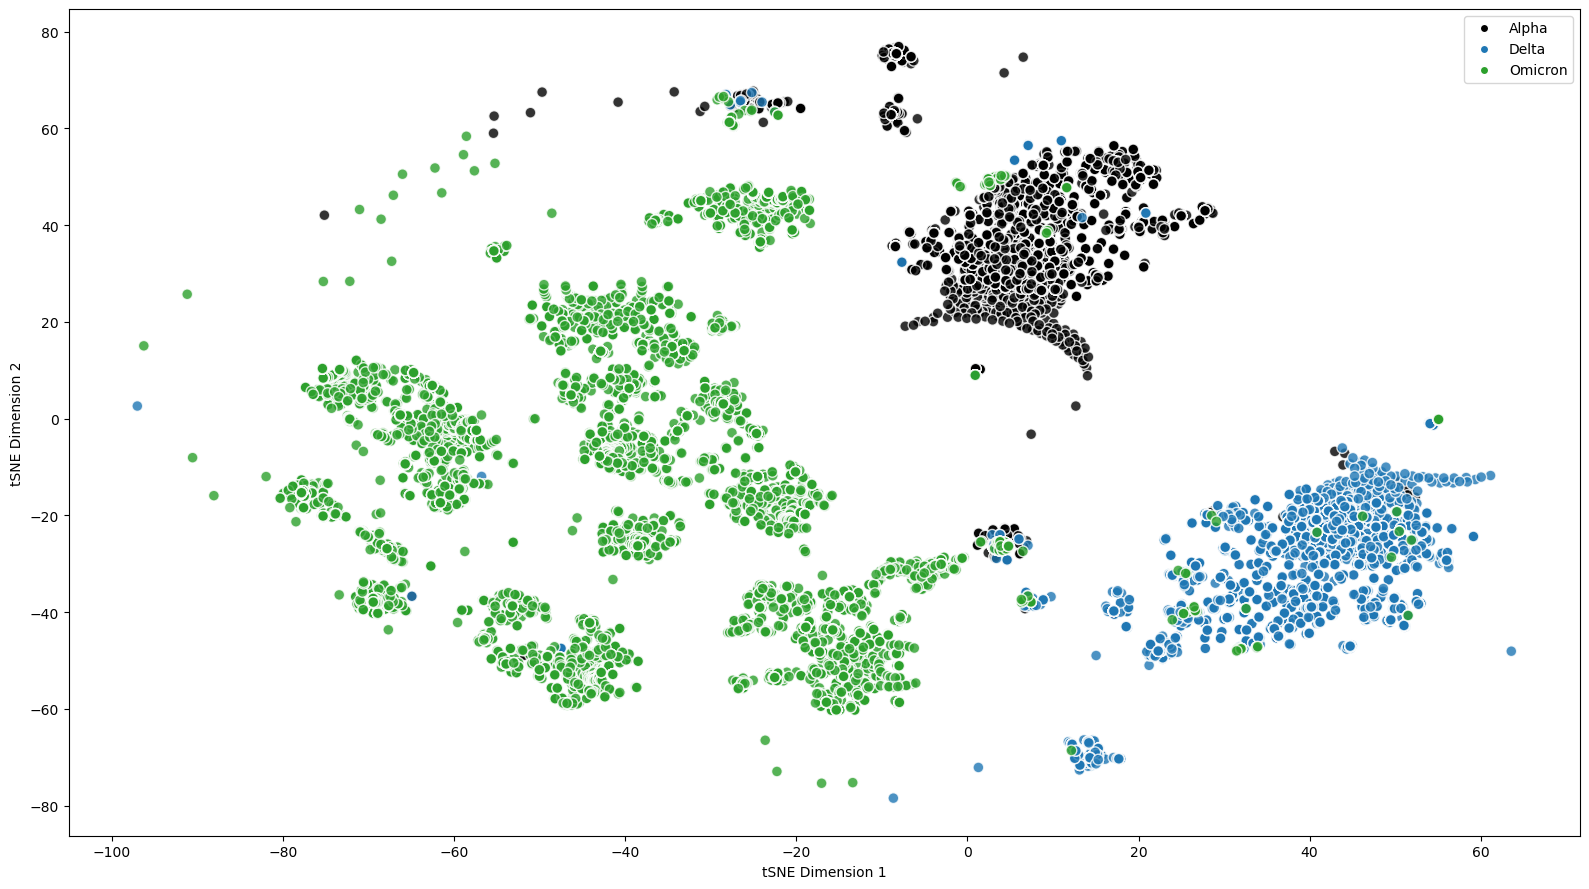

In [3]:
old_run_dir = '../results/run_results/clustering/plot_rbd_cluster-2024-02-26_10-25'
tsne_list = os.path.join(old_run_dir, f"rbd_variants_clustering_esm_blstm_a22073_d22073_o22073_iter0_tsne_coordinates.csv")
plot_from_embedding(tsne_list, 'tSNE')

Here's how we are going to check on the smaller clusters shown above:
1) Select out the region
2) Acquire the coordinates range
3) Extract the sequence IDs in the range

We'll adapt our `plot_from_embedding` function slightly to better vidualize the coordinates of the cluster that we are focusing on.

In [4]:
import matplotlib.patches as patches

def plot_from_embedding(csv_file, type, cluster_range):
    df = pd.read_csv(csv_file, sep=',', header=0)

    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 
            'Delta': 'tab:blue', 
            'Omicron': 'tab:green'}
    
    variant_labels = sorted(df["variant"].unique())
    variant_colors = {}
    for variant in variant_labels:
        if variant in cmap:
            variant_colors[variant] = cmap[variant]

    df['colors'] = [variant_colors[variant] for variant in df['variant']]

    # Legend handles
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_colors[variant], label=variant) for variant in variant_labels]

    # Create a scatter plot
    plt.figure(figsize=(16,9))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.scatter(df['DIM_1'], df['DIM_2'], c=df['colors'], s=60, edgecolor='w', alpha=0.8)

    rect = patches.Rectangle((cluster_range['DIM_1_min'], cluster_range['DIM_2_min']),
                              cluster_range['DIM_1_max'] - cluster_range['DIM_1_min'],
                              cluster_range['DIM_2_max'] - cluster_range['DIM_2_min'],
                              linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')
    plt.legend(handles=legend_handles, loc='upper right')
    plt.tight_layout()
    plt.savefig(csv_file.replace('_coordinates.csv', '_plot.pdf'), format='pdf')

---
## Alpha
Let's replot, and you'll notice that we have outlined a particular cluster based on rough estimate coordinates that are user provided:

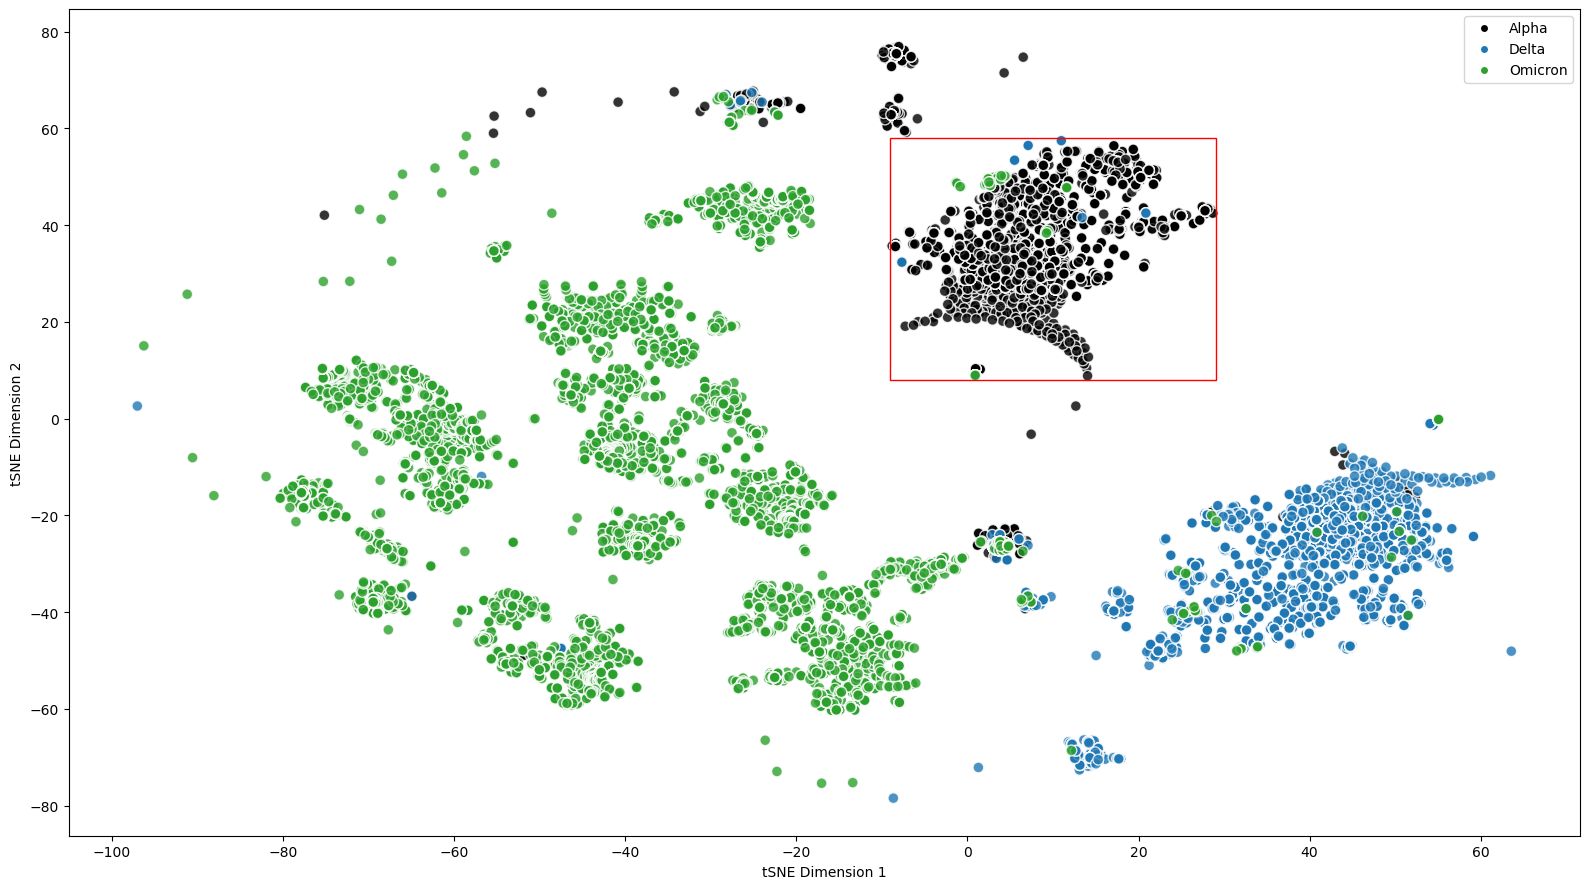

In [5]:
alpha_range = {'DIM_1_min': -9,
               'DIM_1_max': 29,
               'DIM_2_min': 8,
               'DIM_2_max': 58}

plot_from_embedding(tsne_list, 'tSNE', alpha_range)

Let's acquire the sequences IDs from the selected range.

In [6]:
df = pd.read_csv(tsne_list, sep=',', header=0)

alpha_majority_cluster_df = df[(df['DIM_1'] >= alpha_range['DIM_1_min']) &
                               (df['DIM_1'] <= alpha_range['DIM_1_max']) &
                               (df['DIM_2'] >= alpha_range['DIM_2_min']) &
                               (df['DIM_2'] <= alpha_range['DIM_2_max'])]
alpha_majority_cluster_df.reset_index(drop=True, inplace=True)

alpha_majority_cluster_df

,seq_id,variant,DIM_1,DIM_2
0,EPI_ISL_2305967,Alpha,6.189471,33.035965
1,EPI_ISL_1572917,Alpha,18.072947,53.245296
2,EPI_ISL_1247622,Alpha,4.350025,35.653350
3,EPI_ISL_2370551,Alpha,8.425841,52.706833
4,EPI_ISL_1369514,Alpha,5.561197,33.953190
...,...,...,...,...
20757,EPI_ISL_17001757,Omicron,2.508834,48.889320
20758,EPI_ISL_13251021,Omicron,-1.338883,48.811172
20759,EPI_ISL_8547263,Omicron,11.600809,47.749340
20760,EPI_ISL_9877928,Omicron,-1.228372,48.659615


Here is a table showing how many of each variant are in the Alpha majority cluster:

In [7]:
variant_counts = alpha_majority_cluster_df['variant'].value_counts()
variant_percentages = (variant_counts / variant_counts.sum()) * 100

variant_percentage_df = variant_percentages.reset_index()
variant_percentage_df.columns = ['Variant', 'Percentage %']

variant_percentage_df

,Variant,Percentage %
0,Alpha,99.566516
1,Omicron,0.279357
2,Delta,0.154128


Let's read in the full meta data and see what possibilities there are, then merge to our Alpha majority cluster:

In [8]:
data_dir = '../data'
meta_data = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")

metadata_df = pd.read_csv(meta_data, sep='\t', header=0)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})

metadata_df.columns

/tmp/ipykernel_3272951/3203829355.py:4: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd.read_csv(meta_data, sep='\t', header=0)


Index(['Virus name', 'Last vaccinated', 'Passage details/history', 'Type',
       'seq_id', 'Collection date', 'Location',
       'Additional location information', 'Sequence length', 'Host',
       'Patient age', 'Gender', 'Clade', 'Pango lineage', 'Pango version',
       'Variant', 'AA Substitutions', 'Submission date', 'Is reference?',
       'Is complete?', 'Is high coverage?', 'Is low coverage?', 'N-Content',
       'GC-Content'],
      dtype='object')

In [9]:
alpha_merged_df = pd.merge(alpha_majority_cluster_df, metadata_df, on='seq_id', how='left')
alpha_save_as = os.path.join(data_dir, "RBD_alpha_majority_cluster.tsv")
alpha_merged_df.to_csv(alpha_save_as, sep='\t', index=False)

alpha_merged_df

,seq_id,variant,DIM_1,DIM_2,Virus name,Last vaccinated,Passage details/history,Type,Collection date,Location,...,Pango version,Variant,AA Substitutions,Submission date,Is reference?,Is complete?,Is high coverage?,Is low coverage?,N-Content,GC-Content
0,EPI_ISL_2305967,Alpha,6.189471,33.035965,hCoV-19/USA/NC-CDC-LC0060950/2021,NaN,Original,betacoronavirus,2021-05-09,North America / USA / North Carolina,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NS8_Q27stop,NSP3_T183I,Spike_G14...",2021-05-27,NaN,True,NaN,NaN,NaN,0.379720
1,EPI_ISL_1572917,Alpha,18.072947,53.245296,hCoV-19/Germany/BY-RKI-I-068507/2021,NaN,Original,betacoronavirus,2021-03-31,Europe / Germany / Bavaria,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NS8_Q27stop,NSP3_T183I,Spike_T71...",2021-04-13,NaN,True,True,NaN,0.000302,0.379627
2,EPI_ISL_1247622,Alpha,4.350025,35.653350,hCoV-19/England/CAMB-AA3FCC/2021,NaN,Original,betacoronavirus,2021-03-06,Europe / United Kingdom / England,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(NSP2_D449E,Spike_H69del,NS8_Q27stop,NS7a_R80T...",2021-03-15,NaN,True,True,NaN,NaN,0.379868
3,EPI_ISL_2370551,Alpha,8.425841,52.706833,hCoV-19/Greece/186085/2021,NaN,Original,betacoronavirus,2021-04-20,Europe / Greece / Attica,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NS8_Q27stop,Spike_G413R,NSP3_T18...",2021-06-01,NaN,True,True,NaN,0.000234,0.379314
4,EPI_ISL_1369514,Alpha,5.561197,33.953190,hCoV-19/Switzerland/GE-33545638/2021,NaN,Original,betacoronavirus,2021-03-13,Europe / Switzerland / Geneva,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NS8_Q27stop,NSP10_T12I,NSP3_T183...",2021-03-26,NaN,True,True,NaN,NaN,0.379717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20757,EPI_ISL_17001757,Omicron,2.508834,48.889320,hCoV-19/USA/UT-UPHL-230217529191/2023,NaN,Original,betacoronavirus,2023-01-19,North America / USA / Utah,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,NSP3_G489S,Spike_L24del,NSP4_T327I...",2023-02-22,NaN,True,NaN,NaN,NaN,0.379582
20758,EPI_ISL_13251021,Omicron,-1.338883,48.811172,hCoV-19/India/HR-279952672/2022,NaN,Original,betacoronavirus,2022-05-06,Asia / India / Haryana / Faridabad,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,Spike_S371F,NSP3_G489S,NSP13_R392C...",2022-06-13,NaN,True,True,NaN,0.001343,0.379110
20759,EPI_ISL_8547263,Omicron,11.600809,47.749340,hCoV-19/Chile/CO-USACH-00232/2021,NaN,Original,betacoronavirus,2021-12-23,South America / Chile / Coquimbo / Coquimbo,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V...",2022-01-10,NaN,True,NaN,NaN,0.016279,0.380033
20760,EPI_ISL_9877928,Omicron,-1.228372,48.659615,hCoV-19/India/HR-0606000810114/2022,NaN,Original,betacoronavirus,2022-01-10,Asia / India / Haryana / Faridabad,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,NSP3_G489S,NSP13_R392C,Spike_K417N...",2022-02-14,NaN,True,True,NaN,0.000974,0.379234


Let's first take a look at the variant numbers by continent. All values in the table should sum up to 20,762, which represents the total number of 'Continent' values found in the dataset. There are 6 unique continents listed.
- Across the rows, that is how many of each variant appears in the specific continent.
- Down the columns, that is how many times the specific variant appears in each continent.

In [10]:
def variant_by_continent(merged_df, variant: str):
    """By Variant Numbers by Continent, showing only percentages."""

    # Copy the data
    continent_df = merged_df[['variant', 'Location']].copy()

    # Acquire continent from Location column
    continent_df['Continent'] = continent_df['Location'].apply(lambda x: x.split('/')[0].strip())

    # Group by continent based on the variant counts
    continent_variant_df = continent_df.groupby('Continent')['variant'].value_counts().reset_index(name='count')

    # Pivot so that you can see the values per variant
    continent_variant_df = continent_variant_df.pivot(index='Continent', columns='variant', values='count').reset_index()

    # Fill in 0s for NaN values, convert floats to int
    continent_variant_df = continent_variant_df.fillna(0).astype({col: 'int' for col in continent_variant_df.columns if col != 'Continent'})

    # Ignore index column name
    continent_variant_df.columns.name = None

    # Total of all values
    total_sum_value = continent_variant_df.drop(columns=['Continent']).sum().sum()

    # Calculate percentages for each variant and create new columns
    for col in continent_variant_df.columns[1:]:  # Skipping 'Continent' column
        continent_variant_df[f'{col} %'] = (continent_variant_df[col] / total_sum_value) * 100

    # Drop the count columns, keep only 'Continent' and percentage columns
    percentage_columns = ['Continent'] + [f'{col}' for col in continent_variant_df.columns[1:] if '%' in col]
    continent_percentage_variant_df = continent_variant_df[percentage_columns]

    # Sort from most specified variant values to least
    continent_percentage_variant_df = continent_percentage_variant_df.sort_values(by=f"{variant} %", ascending=False).reset_index(drop=True)

    # Output the total values as well
    print(f"Total values in table: {total_sum_value}")
    print(f"Individual '*%' columns do not add to 100%, the entire table adds to 100%")

    return continent_percentage_variant_df 

variant_by_continent(alpha_merged_df, "Alpha")

Total values in table: 20762
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Continent,Alpha %,Delta %,Omicron %
0,Europe,66.905886,0.105963,0.004816
1,North America,24.756767,0.028899,0.187843
2,Asia,6.324054,0.014449,0.081880
3,South America,0.919950,0.004816,0.004816
4,Africa,0.568346,0.000000,0.000000
5,Oceania,0.091513,0.000000,0.000000


Now let's take a look at the variant numbers by hosts. All values in the table should sum up to 20,762, which represents the total number of 'Host' values found in the dataset. There are 5 unique hosts listed.
- Across the rows, that is how many of each variant appears in the specific host.
- Down the columns, that is how many times the specific variant appears in each host.

In [11]:
def variant_by_host(merged_df, variant:str):
    """ By Variant Numbers by Host. """
    host_df = merged_df[['variant', 'Host']].copy()
    host_variant_df = host_df.groupby('Host')['variant'].value_counts().reset_index()
    host_variant_df = host_variant_df.pivot(index='Host', columns='variant', values='count').reset_index()
    host_variant_df = host_variant_df.fillna(0).astype({col: 'int' for col in host_variant_df.columns if col != 'Host'})
    host_variant_df.columns.name = None
    total_sum_value = host_variant_df.drop(columns=['Host']).sum().sum()
    for col in host_variant_df.columns[1:]:  # Skipping 'Host' column
        host_variant_df[f'{col} %'] = (host_variant_df[col] / total_sum_value) * 100
    percentage_columns = ['Host'] + [f'{col}' for col in host_variant_df.columns[1:] if '%' in col]
    host_percentage_variant_df = host_variant_df[percentage_columns]
    host_percentage_variant_df = host_percentage_variant_df.sort_values(by=f"{variant} %", ascending=False).reset_index(drop=True)
    print(f"Total values in table: {total_sum_value}")
    print(f"Individual '*%' columns do not add to 100%, the entire table adds to 100%")
    return host_percentage_variant_df

variant_by_host(alpha_merged_df, "Alpha")

Total values in table: 20762
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Host,Alpha %,Delta %,Omicron %
0,Human,99.446103,0.154128,0.279357
1,Environment,0.057798,0.000000,0.000000
2,Odocoileus virginianus,0.052981,0.000000,0.000000
3,Neogale vison,0.004816,0.000000,0.000000
4,Neovison vison,0.004816,0.000000,0.000000


Let's try mapping the variant with the date collected (Year and Month), then plotting it:

<Figure size 1600x900 with 0 Axes>

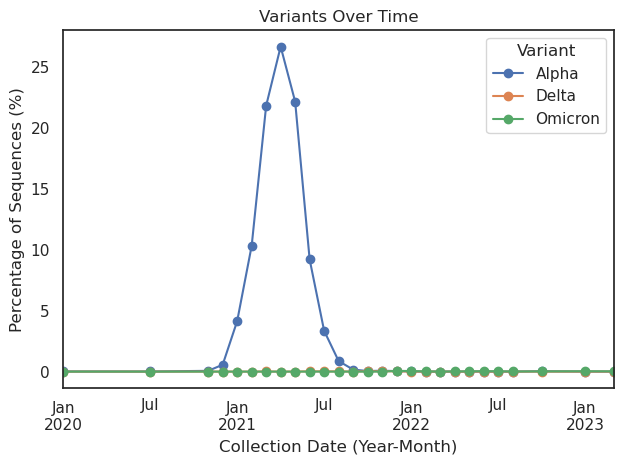

In [12]:
def date_collected_vs_variant(save_as, merged_df):
    """Analyze and visualize variant distributions over collection dates represented as percentages of the total across the entire dataset."""

    # Apply seaborn style
    sns.set_theme(style="white")

    # Ensure 'Collection date' is a datetime object
    merged_df['Collection date'] = pd.to_datetime(merged_df['Collection date'], format='mixed')

    # Aggregate data: count variants for each collection date, aggregating by month
    merged_df['YearMonth'] = merged_df['Collection date'].dt.to_period('M')
    date_variant_df = merged_df.groupby(['YearMonth', 'variant']).size().unstack(fill_value=0)

    # Calculate the grand total counts across the entire dataset
    grand_total_count = date_variant_df.sum().sum()

    # Convert the counts to percentages of the total across the entire dataset
    date_variant_df_percentage = date_variant_df.div(grand_total_count) * 100

    # Visualization: Time series plot for each variant with percentages
    plt.figure(figsize=(16, 9))
    date_variant_df_percentage.plot(kind='line', marker='o')
    plt.title('Variants Over Time')
    plt.xlabel('Collection Date (Year-Month)')
    plt.ylabel('Percentage of Sequences (%)')
    plt.legend(title='Variant')
    plt.tight_layout()
    plt.savefig(save_as, format='pdf')

save_as = os.path.join(old_run_dir, "data_collected_variant_alpha_cluster.pdf")
date_collected_vs_variant(save_as, alpha_merged_df)

Now let's take a look at the variant numbers by Pango lineage. All values in the table should sum up to 20,762, which represents the total number of 'Pango lineage' values found in the dataset. There are 210 unique Pango lineages listed.
- Across the rows, that is how many of each variant appears in the specific Pango lineage.
- Down the columns, that is how many times the specific variant appears in each Pango lineage.

In [13]:
def variant_by_pango_lineage(merged_df, variant:str):
    """ By Variant Numbers by Pango lineage. """
    pango_lineage_df = merged_df[['variant', 'Pango lineage']].copy()
    pango_lineage_variant_df = pango_lineage_df.groupby('Pango lineage')['variant'].value_counts().reset_index()
    pango_lineage_variant_df = pango_lineage_variant_df.pivot(index='Pango lineage', columns='variant', values='count').reset_index()
    pango_lineage_variant_df = pango_lineage_variant_df.fillna(0).astype({col: 'int' for col in pango_lineage_variant_df.columns if col != 'Pango lineage'})
    pango_lineage_variant_df.columns.name = None
    total_sum_value = pango_lineage_variant_df.drop(columns=['Pango lineage']).sum().sum()
    for col in pango_lineage_variant_df.columns[1:]:  # Skipping 'Pango lineage' column
        pango_lineage_variant_df[f'{col} %'] = (pango_lineage_variant_df[col] / total_sum_value) * 100
    percentage_columns = ['Pango lineage'] + [f'{col}' for col in pango_lineage_variant_df.columns[1:] if '%' in col]
    pango_lineage_percentage_variant_df = pango_lineage_variant_df[percentage_columns]
    pango_lineage_percentage_variant_df = pango_lineage_percentage_variant_df.sort_values(by=f"{variant} %", ascending=False).reset_index(drop=True)
    print(f"Total values in table: {total_sum_value}")
    print(f"Individual '*%' columns do not add to 100%, the entire table adds to 100%")
    return pango_lineage_percentage_variant_df

variant_by_pango_lineage(alpha_merged_df, "Alpha")

Total values in table: 20762
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Pango lineage,Alpha %,Delta %,Omicron %
0,B.1.1.7,97.148637,0.000000,0.000000
1,Q.3,0.915133,0.000000,0.000000
2,Q.4,0.544264,0.000000,0.000000
3,Q.1,0.496099,0.000000,0.000000
4,Q.2,0.115596,0.000000,0.000000
5,B.1.1,0.101146,0.000000,0.000000
6,Q.7,0.096330,0.000000,0.000000
7,B.1,0.057798,0.014449,0.000000
8,Q.8,0.024082,0.000000,0.000000
9,Q.6,0.009633,0.000000,0.000000


Let's take a closer look at the Pango lineage by splitting the 'Collection date' column by year. This way we can see the trend of number of samples for the Pango lineage. We'll also hyphenate the Pango lineage with variant.

In [14]:
def variant_by_pango_lineage_yearly(merged_df):
    """By Variant Numbers and Pango lineage with Yearly Aggregations, displaying percentages based on total values for each year across the dataset,
    with a combined 'Pango lineage-variant' column."""

    # Copy relevant data including 'variant'
    pango_lineage_df = merged_df[['variant', 'Pango lineage', 'Collection date']].copy()

    # Convert 'Collection date' to datetime, handling mixed format
    pango_lineage_df['Collection date'] = pd.to_datetime(pango_lineage_df['Collection date'], format='mixed')

    # Extract year from 'Collection date'
    pango_lineage_df['Year'] = pango_lineage_df['Collection date'].dt.year

    # Aggregate counts by Variant, Pango lineage, and Year
    lineage_year_df = pango_lineage_df.groupby(['variant', 'Pango lineage', 'Year']).size().unstack(fill_value=0).reset_index()

    # Create a new 'Pango lineage-variant' column
    lineage_year_df['Pango lineage-variant'] = lineage_year_df['Pango lineage'] + '-' + lineage_year_df['variant']

    # Drop the now-redundant 'Pango lineage' and 'variant' columns
    lineage_year_df = lineage_year_df.drop(['Pango lineage', 'variant'], axis=1)

    # Ensure all relevant year columns exist, fill missing with 0
    years = sorted(pango_lineage_df['Year'].unique())
    for year in years:
        if year not in lineage_year_df.columns[:-1]:  # Exclude the new combined column for this check
            lineage_year_df[year] = 0
    lineage_year_df = lineage_year_df.fillna(0).astype({year: 'int' for year in years})

    # Calculate the total counts for each year across the entire dataset
    total_counts_by_year = lineage_year_df[years].sum()

    # Convert counts to percentages based on the total for each year
    lineage_year_df[years] = lineage_year_df[years].div(total_counts_by_year) * 100

    # Move 'Pango lineage-variant' column to the front
    cols = lineage_year_df.columns.tolist()
    cols = [cols[-1]] + cols[:-1]
    lineage_year_df = lineage_year_df[cols]

    # Sort the DataFrame by the new 'Pango lineage-variant' column
    lineage_year_df = lineage_year_df.sort_values(by='Pango lineage-variant').reset_index(drop=True)
    lineage_year_df.columns.name = None

    return lineage_year_df

variant_by_pango_lineage_yearly(alpha_merged_df)

,Pango lineage-variant,2020,2021,2022,2023
0,AY.100-Delta,0.0,0.004862,0.0,0.0
1,AY.110-Delta,0.0,0.004862,0.0,0.0
2,AY.119-Delta,0.0,0.004862,0.0,0.0
3,AY.121-Delta,0.0,0.004862,0.0,0.0
4,AY.122-Delta,0.0,0.019449,0.0,0.0
5,AY.125-Delta,0.0,0.004862,0.0,0.0
6,AY.126-Delta,0.0,0.004862,0.0,0.0
7,AY.127-Delta,0.0,0.004862,0.0,0.0
8,AY.25-Delta,0.0,0.004862,0.0,0.0
9,AY.3-Delta,0.0,0.004862,2.0,0.0


Now let's take a look at the variant numbers by AA Substitutions. All values in the table should sum up to 634,241, which represents the total number of 'AA substitution' values found in the dataset. There are 9654 unique AA substitutions listed.
- Across the rows, that is how many of each variant appears in the specific AA substitution.
- Down the columns, that is how many times the specific variant appears in each AA substitution.

In [15]:
def variant_by_aa_substitution(merged_df, variant:str):
    """ By Variant Numbers by Pango lineage. """
    pango_lineage_df = merged_df[['variant', 'Pango lineage']].copy()
    pango_lineage_variant_df = pango_lineage_df.groupby('Pango lineage')['variant'].value_counts().reset_index()
    pango_lineage_variant_df = pango_lineage_variant_df.pivot(index='Pango lineage', columns='variant', values='count').reset_index()
    pango_lineage_variant_df = pango_lineage_variant_df.fillna(0).astype({col: 'int' for col in pango_lineage_variant_df.columns if col != 'Pango lineage'})
    pango_lineage_variant_df.columns.name = None
    total_sum_value = pango_lineage_variant_df.drop(columns=['Pango lineage']).sum().sum()
    for col in pango_lineage_variant_df.columns[1:]:  # Skipping 'Pango lineage' column
        pango_lineage_variant_df[f'{col} %'] = (pango_lineage_variant_df[col] / total_sum_value) * 100
    percentage_columns = ['Pango lineage'] + [f'{col}' for col in pango_lineage_variant_df.columns[1:] if '%' in col]
    pango_lineage_percentage_variant_df = pango_lineage_variant_df[percentage_columns]
    pango_lineage_percentage_variant_df = pango_lineage_percentage_variant_df.sort_values(by=f"{variant} %", ascending=False).reset_index(drop=True)
    print(f"Total values in table: {total_sum_value}")
    print(f"Individual '*%' columns do not add to 100%, the entire table adds to 100%")
    return pango_lineage_percentage_variant_df

variant_by_pango_lineage(alpha_merged_df, "Alpha")

Total values in table: 20762
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Pango lineage,Alpha %,Delta %,Omicron %
0,B.1.1.7,97.148637,0.000000,0.000000
1,Q.3,0.915133,0.000000,0.000000
2,Q.4,0.544264,0.000000,0.000000
3,Q.1,0.496099,0.000000,0.000000
4,Q.2,0.115596,0.000000,0.000000
5,B.1.1,0.101146,0.000000,0.000000
6,Q.7,0.096330,0.000000,0.000000
7,B.1,0.057798,0.014449,0.000000
8,Q.8,0.024082,0.000000,0.000000
9,Q.6,0.009633,0.000000,0.000000


In [16]:
def variant_by_aa_substitution(merged_df, variant:str):
    """ By Variant Numbers by AA Substitution. """
    aa_substitution_df = merged_df[['variant', 'AA Substitutions']].copy()

    # Strip beginning and end parentheses, split to separate variants. If not in this format, replace as unknown
    aa_substitution_df['AA Substitution'] = aa_substitution_df['AA Substitutions'].apply(
        lambda x: x.strip('()').split(',') if isinstance(x, str) else ['unknown'])

    # Explode values to their own row
    aa_substitution_df = aa_substitution_df.explode('AA Substitution').drop('AA Substitutions', axis=1).reset_index()
    aa_substitution_variant_df = aa_substitution_df.groupby('AA Substitution')['variant'].value_counts().reset_index()
    aa_substitution_variant_df = aa_substitution_variant_df.pivot(index='AA Substitution', columns='variant', values='count').reset_index()
    aa_substitution_variant_df = aa_substitution_variant_df.fillna(0).astype({col: 'int' for col in aa_substitution_variant_df.columns if col != 'AA Substitution'})
    aa_substitution_variant_df.columns.name = None
    total_sum_value = aa_substitution_variant_df.drop(columns=['AA Substitution']).sum().sum()
    for col in aa_substitution_variant_df.columns[1:]:  # Skipping 'AA Substitution' column
        aa_substitution_variant_df[f'{col} %'] = (aa_substitution_variant_df[col] / total_sum_value) * 100
    percentage_columns = ['AA Substitution'] + [f'{col}' for col in aa_substitution_variant_df.columns[1:] if '%' in col]    
    aa_substitution_percentage_variant_df = aa_substitution_variant_df[percentage_columns]
    aa_substitution_percentage_variant_df = aa_substitution_percentage_variant_df.sort_values(by=f"{variant} %", ascending=False).reset_index(drop=True)
    print(f"Total values in table: {total_sum_value}")
    print(f"Individual '*%' columns do not add to 100%, the entire table adds to 100%")
    return aa_substitution_percentage_variant_df

alpha_aa_substitution_variant_df = variant_by_aa_substitution(alpha_merged_df, "Alpha")
alpha_aa_substitution_variant_df 

Total values in table: 634241
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,AA Substitution,Alpha %,Delta %,Omicron %
0,Spike_N501Y,3.253495,0.001577,0.005361
1,Spike_D614G,3.244193,0.005045,0.008672
2,NSP12_P323L,3.238832,0.005045,0.008987
3,NSP3_T183I,3.228268,0.000000,0.000000
4,N_S235F,3.222119,0.000158,0.000000
...,...,...,...,...
22427,NSP13_R337L,0.000000,0.000473,0.000000
22428,NSP3_R568L,0.000000,0.000473,0.000000
22429,NSP14_D331Y,0.000000,0.000473,0.000000
22430,NSP2_E162stop,0.000000,0.000473,0.000000


Let's take an even closer look at this column by focusing on the mutations that occur in the Spike Protein:

In [17]:
# == By Variant Numbers by AA Substitution, Spike Protein Focus ==

# Filter rows where 'AA Substitution' contains 'Spike'
alpha_spike_aa_substitutions_df = alpha_aa_substitution_variant_df[alpha_aa_substitution_variant_df['AA Substitution'].str.contains('Spike')].reset_index(drop=True)
print(f"Total values in table: {alpha_spike_aa_substitutions_df.drop(columns=['AA Substitution']).sum().sum()}")
alpha_spike_aa_substitutions_df

Total values in table: 39.12881696389858


,AA Substitution,Alpha %,Delta %,Omicron %
0,Spike_N501Y,3.253495,0.001577,0.005361
1,Spike_D614G,3.244193,0.005045,0.008672
2,Spike_D1118H,3.203356,0.000315,0.000000
3,Spike_S982A,3.203356,0.000315,0.000000
4,Spike_A570D,3.203041,0.000158,0.000000
...,...,...,...,...
5435,Spike_G339H,0.000000,0.000000,0.001577
5436,Spike_N540I,0.000000,0.000315,0.000000
5437,Spike_P681L,0.000000,0.000473,0.000000
5438,Spike_L452R,0.000000,0.002996,0.000000


---
## Delta

Let's do the similar for the Delta cluster here.

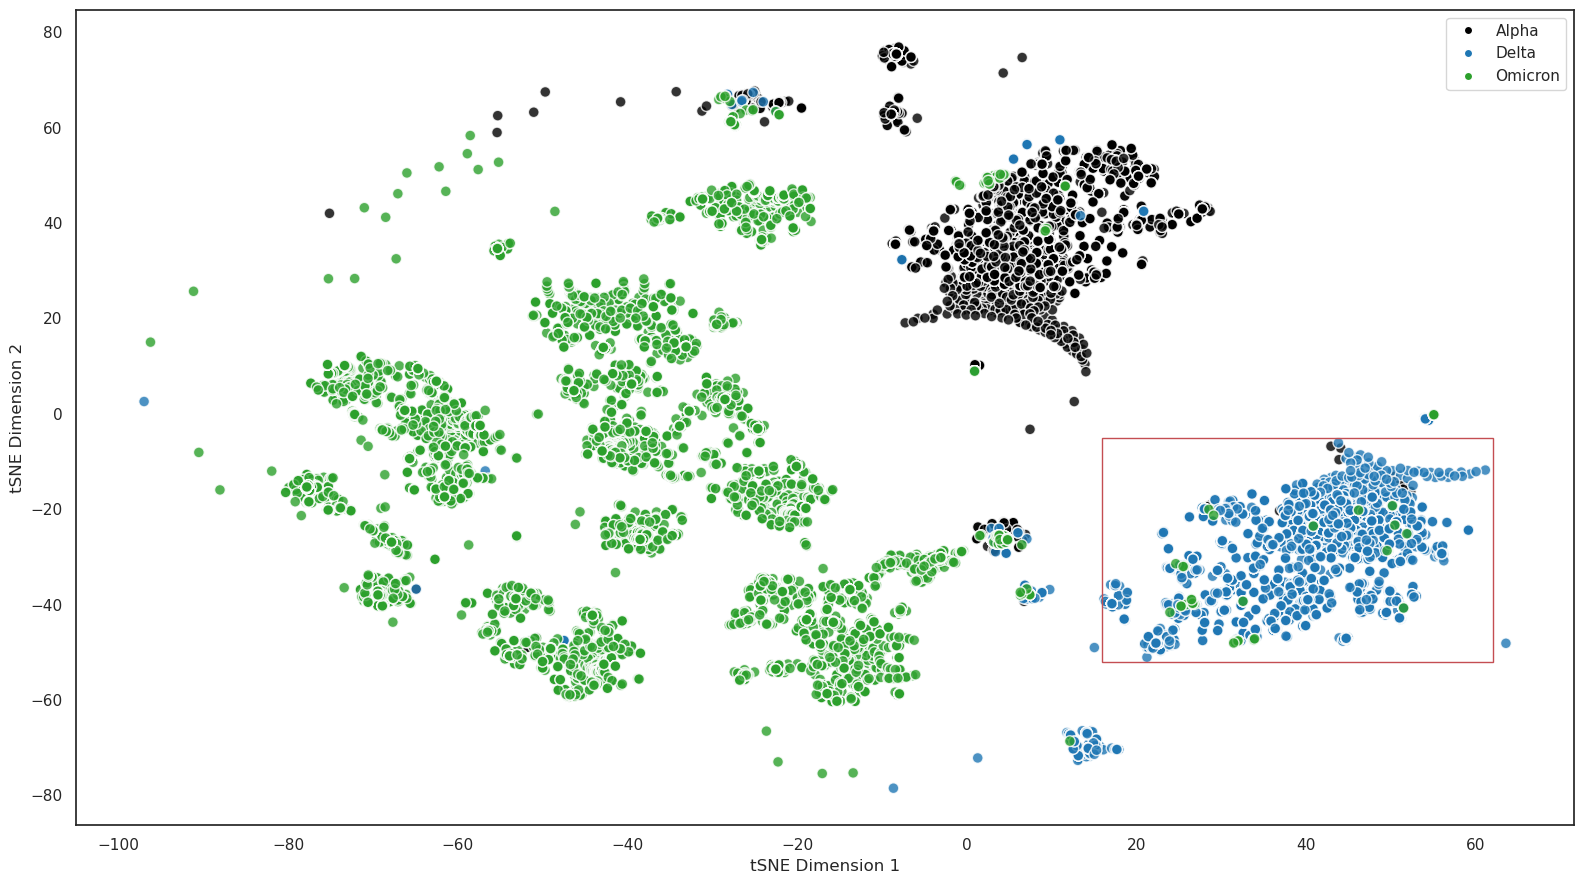

In [18]:
delta_range = {'DIM_1_min': 16,
               'DIM_1_max': 62,
               'DIM_2_min': -52,
               'DIM_2_max': -5}

plot_from_embedding(tsne_list, 'tSNE', delta_range)

In [19]:
delta_majority_cluster_df = df[(df['DIM_1'] >= delta_range['DIM_1_min']) &
                               (df['DIM_1'] <= delta_range['DIM_1_max']) &
                               (df['DIM_2'] >= delta_range['DIM_2_min']) &
                               (df['DIM_2'] <= delta_range['DIM_2_max'])]
delta_majority_cluster_df.reset_index(drop=True, inplace=True)

delta_majority_cluster_df

,seq_id,variant,DIM_1,DIM_2
0,EPI_ISL_3186432,Alpha,42.982727,-27.569954
1,EPI_ISL_3100260,Alpha,43.890430,-9.592770
2,EPI_ISL_2981220,Alpha,44.096703,-7.172695
3,EPI_ISL_3419096,Alpha,42.938118,-6.787346
4,EPI_ISL_4369366,Alpha,28.022387,-19.925276
...,...,...,...,...
5147,EPI_ISL_15866869,Omicron,26.497143,-38.922894
5148,EPI_ISL_9594672,Omicron,33.927770,-47.153570
5149,EPI_ISL_16504290,Omicron,31.465405,-48.026035
5150,EPI_ISL_11036999,Omicron,25.262974,-40.301290


In [20]:
variant_counts = delta_majority_cluster_df['variant'].value_counts()
variant_percentages = (variant_counts / variant_counts.sum()) * 100

variant_percentage_df = variant_percentages.reset_index()
variant_percentage_df.columns = ['Variant', 'Percentage']

variant_percentage_df

,Variant,Percentage
0,Delta,97.340839
1,Alpha,1.805124
2,Omicron,0.854037


In [21]:
delta_merged_df = pd.merge(delta_majority_cluster_df, metadata_df, on='seq_id', how='left')
delta_save_as = os.path.join(data_dir, "RBD_delta_majority_cluster.tsv")
delta_merged_df.to_csv(delta_save_as, sep='\t', index=False)

delta_merged_df

,seq_id,variant,DIM_1,DIM_2,Virus name,Last vaccinated,Passage details/history,Type,Collection date,Location,...,Pango version,Variant,AA Substitutions,Submission date,Is reference?,Is complete?,Is high coverage?,Is low coverage?,N-Content,GC-Content
0,EPI_ISL_3186432,Alpha,42.982727,-27.569954,hCoV-19/Sweden/1924242664/2021,NaN,Original,betacoronavirus,2021-07-19,Europe / Sweden / Vastragotaland / Skovde,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NSP2_Y5H,NSP6_S106del,Spike_A570...",2021-08-02,NaN,True,True,NaN,0.007546,0.379055
1,EPI_ISL_3100260,Alpha,43.890430,-9.592770,hCoV-19/Sweden/1923587464/2021,NaN,Original,betacoronavirus,2021-07-05,Europe / Sweden / Vastragotaland / Skovde,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NS8_Q27stop,NSP3_T183I,Spike_T71...",2021-07-28,NaN,True,True,NaN,0.001006,0.379696
2,EPI_ISL_2981220,Alpha,44.096703,-7.172695,hCoV-19/Netherlands/LI-RIVM-42326/2021,NaN,Original,betacoronavirus,2021-06-14,Europe / Netherlands / Limburg,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NSP3_T183I,NSP12_G671S,Spike_T71...",2021-07-16,NaN,True,True,NaN,NaN,0.379691
3,EPI_ISL_3419096,Alpha,42.938118,-6.787346,hCoV-19/USA/NC-CLT-000309/2021,NaN,Original,betacoronavirus,2021-07-14,North America / USA / North Carolina / Harnett...,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,NSP8_T145I,NSP6_G107del,NSP6_S10...",2021-08-16,NaN,True,True,NaN,NaN,0.380271
4,EPI_ISL_4369366,Alpha,28.022387,-19.925276,hCoV-19/USA/NY-CDC-QDX25930593/2021,NaN,Original,betacoronavirus,2021-06-14,North America / USA / New York,...,PLEARN-v1.19,VOC Alpha GRY (B.1.1.7+Q.*) first detected in ...,"(Spike_H69del,Spike_T716I,NSP6_S106del,N_R203K...",2021-09-21,NaN,True,True,NaN,0.002184,0.380181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5147,EPI_ISL_15866869,Omicron,26.497143,-38.922894,hCoV-19/Panama/M265580-GMI/2022,NaN,Original,betacoronavirus,2022-10-26,North America / Panama / Panama Center / Juan ...,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,NSP3_G489S,Spike_L24del,NSP4_T327I...",2022-11-22,NaN,True,NaN,NaN,0.008404,0.378818
5148,EPI_ISL_9594672,Omicron,33.927770,-47.153570,hCoV-19/USA/WA-CDC-UW22012585005/2022,NaN,Original,betacoronavirus,2022-01-25,North America / USA / Washington,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,Spike_H69del,Spike_T95I,Spike_A67V...",2022-02-06,NaN,True,NaN,NaN,NaN,0.379101
5149,EPI_ISL_16504290,Omicron,31.465405,-48.026035,hCoV-19/Brazil/MA-LACENMA-210219915/2022,NaN,Original,betacoronavirus,2022-11,South America / Brazil / Maranhao / Sao Luis,...,PLEARN-v1.19,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d...",2023-01-12,NaN,True,NaN,NaN,NaN,0.378883
5150,EPI_ISL_11036999,Omicron,25.262974,-40.301290,hCoV-19/France/NOR_UCN_CHU-Caen_1126512214/2021,NaN,Original,betacoronavirus,2021-12-28,Europe / France / Normandie,...,consensus call,VOC Omicron GRA (B.1.1.529+BA.*) first detecte...,"(Spike_H69del,Spike_T95I,Spike_A67V,NSP6_S106d...",2022-03-15,NaN,True,True,NaN,NaN,0.379313


In [22]:
# == By Variant Numbers by Continent ==
variant_by_continent(delta_merged_df, "Delta")

Total values in table: 5152
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Continent,Alpha %,Delta %,Omicron %
0,Europe,0.951087,47.418478,0.329969
1,North America,0.698758,34.937888,0.329969
2,Asia,0.116460,11.490683,0.135870
3,South America,0.019410,2.096273,0.058230
4,Africa,0.019410,1.028727,0.000000
5,Oceania,0.000000,0.368789,0.000000


In [23]:
# == By Variant Numbers by Host ==
variant_by_host(delta_merged_df, "Delta")

Total values in table: 5152
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Host,Alpha %,Delta %,Omicron %
0,Human,1.805124,97.224379,0.815217
1,Environment,0.000000,0.058230,0.038820
2,Neovison vison,0.000000,0.019410,0.000000
3,Odocoileus virginianus,0.000000,0.019410,0.000000
4,unknown,0.000000,0.019410,0.000000


In [24]:
# == By Variant Numbers by Pango lineage ==
variant_by_pango_lineage(delta_merged_df, "Delta")

Total values in table: 5152
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,Pango lineage,Alpha %,Delta %,Omicron %
0,AY.4,0.00000,12.538820,0.019410
1,B.1.617.2,0.00000,7.104037,0.077640
2,AY.122,0.01941,6.250000,0.000000
3,AY.103,0.00000,5.570652,0.000000
4,AY.43,0.00000,5.046584,0.000000
...,...,...,...,...
205,BA.1.1,0.00000,0.000000,0.019410
206,B.1.1.529,0.00000,0.000000,0.368789
207,B.1.1.50,0.01941,0.000000,0.000000
208,B.1.1,0.01941,0.000000,0.000000


In [25]:
# == By Variant Numbers by AA Substitution ==
delta_aa_substitution_variant_df = variant_by_aa_substitution(delta_merged_df, "Delta")
delta_aa_substitution_variant_df 

Total values in table: 185101
Individual '*%' columns do not add to 100%, the entire table adds to 100%


,AA Substitution,Alpha %,Delta %,Omicron %
0,Spike_D614G,0.050243,2.703389,0.022690
1,Spike_L452R,0.049162,2.687182,0.022150
2,Spike_P681R,0.004862,2.680158,0.004862
3,Spike_T478K,0.024311,2.660710,0.019989
4,Spike_T19R,0.007563,2.654227,0.003782
...,...,...,...,...
9649,NSP3_V929F,0.000000,0.000000,0.000540
9650,NSP3_V965I,0.000540,0.000000,0.000000
9651,N_K248R,0.000000,0.000000,0.000540
9652,NSP3_E114K,0.000000,0.000000,0.000540


In [26]:
# == By Variant Numbers by AA Substitution, Spike Protein Focus ==

# Filter rows where 'AA Substitution' contains 'Spike'
delta_spike_aa_substitutions_df = delta_aa_substitution_variant_df[delta_aa_substitution_variant_df['AA Substitution'].str.contains('Spike')].reset_index(drop=True)
delta_spike_aa_substitutions_df

,AA Substitution,Alpha %,Delta %,Omicron %
0,Spike_D614G,0.050243,2.703389,0.022690
1,Spike_L452R,0.049162,2.687182,0.022150
2,Spike_P681R,0.004862,2.680158,0.004862
3,Spike_T478K,0.024311,2.660710,0.019989
4,Spike_T19R,0.007563,2.654227,0.003782
...,...,...,...,...
2191,Spike_N17S,0.000540,0.000000,0.000000
2192,Spike_N185Y,0.000000,0.000000,0.000540
2193,Spike_V213G,0.000000,0.000000,0.005402
2194,Spike_L179I,0.000540,0.000000,0.000000


---
## Omicron
Let's compare separate Omicron clusters, specifically looking at only Omicron data points.

In [27]:
import matplotlib.patches as patches

def plot_from_embedding_multi_variant(csv_file, type, cluster_ranges: list):
    df = pd.read_csv(csv_file, sep=',', header=0)

    sns.set_theme(style="white")

    # Custom color mapping for specified variants
    cmap = {'Alpha': 'black', 'Delta': 'tab:blue', 'Omicron': 'tab:green'}
    
    variant_labels = sorted(df["variant"].unique())
    variant_colors = {variant: cmap[variant] for variant in variant_labels}

    df['colors'] = [variant_colors[variant] for variant in df['variant']]

    # Legend handles
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=variant_colors[variant], label=variant) for variant in variant_labels]

    # Create a scatter plot
    plt.figure(figsize=(16, 9))
    plt.rcParams['font.family'] = 'sans-serif'
    plt.scatter(df['DIM_1'], df['DIM_2'], c=df['colors'], s=60, edgecolor='w', alpha=0.5)

    # Draw multiple rectangles with labels for cluster ranges
    for idx, cluster_range in enumerate(cluster_ranges, 1):  # Start enumeration at 1 for cluster labeling
        rect = patches.Rectangle((cluster_range['DIM_1_min'], cluster_range['DIM_2_min']),
                                  cluster_range['DIM_1_max'] - cluster_range['DIM_1_min'],
                                  cluster_range['DIM_2_max'] - cluster_range['DIM_2_min'],
                                  linewidth=3, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        # Labeling the rectangle
        plt.text(cluster_range['DIM_1_min'], cluster_range['DIM_2_max']+1, f'{idx}', color='red', fontsize=20)

    plt.xlabel(f'{type} Dimension 1')
    plt.ylabel(f'{type} Dimension 2')
    plt.legend(handles=legend_handles, loc='upper right')
    plt.tight_layout()
    plt.savefig(csv_file.replace('_coordinates.csv', f'_plot_{type}_multi_variant.pdf'), format='pdf')

This function is altered from before. Now we look at additional information for the single variant, specifically the Pango lineages within a cluster, and also these values from within the entire subsampled dataset.

In [40]:
def pango_lineage_cluster_lineage_percent_single_variant(cluster_df, subsampled_df):
    """ By Variant Numbers by Pango lineage with percentages for both cluster and overall dataset. """
    
    cluster_df = cluster_df.copy()
    subsampled_df = subsampled_df.copy()

    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    cluster_df['Pango lineage'] = cluster_df['Pango lineage'].apply(trunc_format)
    subsampled_df['Pango lineage'] = subsampled_df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within the cluster
    cluster_counts = cluster_df.groupby('Pango lineage').size().reset_index(name='Cluster count')

    # Calculate lineage counts within the entire subsampled dataset
    total_counts = subsampled_df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts['Cluster count'].sum()) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort the DataFrame by 'Cluster %'
    lineage_counts = lineage_counts.sort_values(by='Cluster %', ascending=False).reset_index(drop=True)

    return lineage_counts

Visually, these should only be Omicron data points. This can be confirmed in the ` date_collected_vs_variant` plots, where only Omicron should be plotted instead of any Delta or Alpha. Clusters 1-3 make up Supplementary Figure 4 and Supplementary Table 1 in the manuscript.

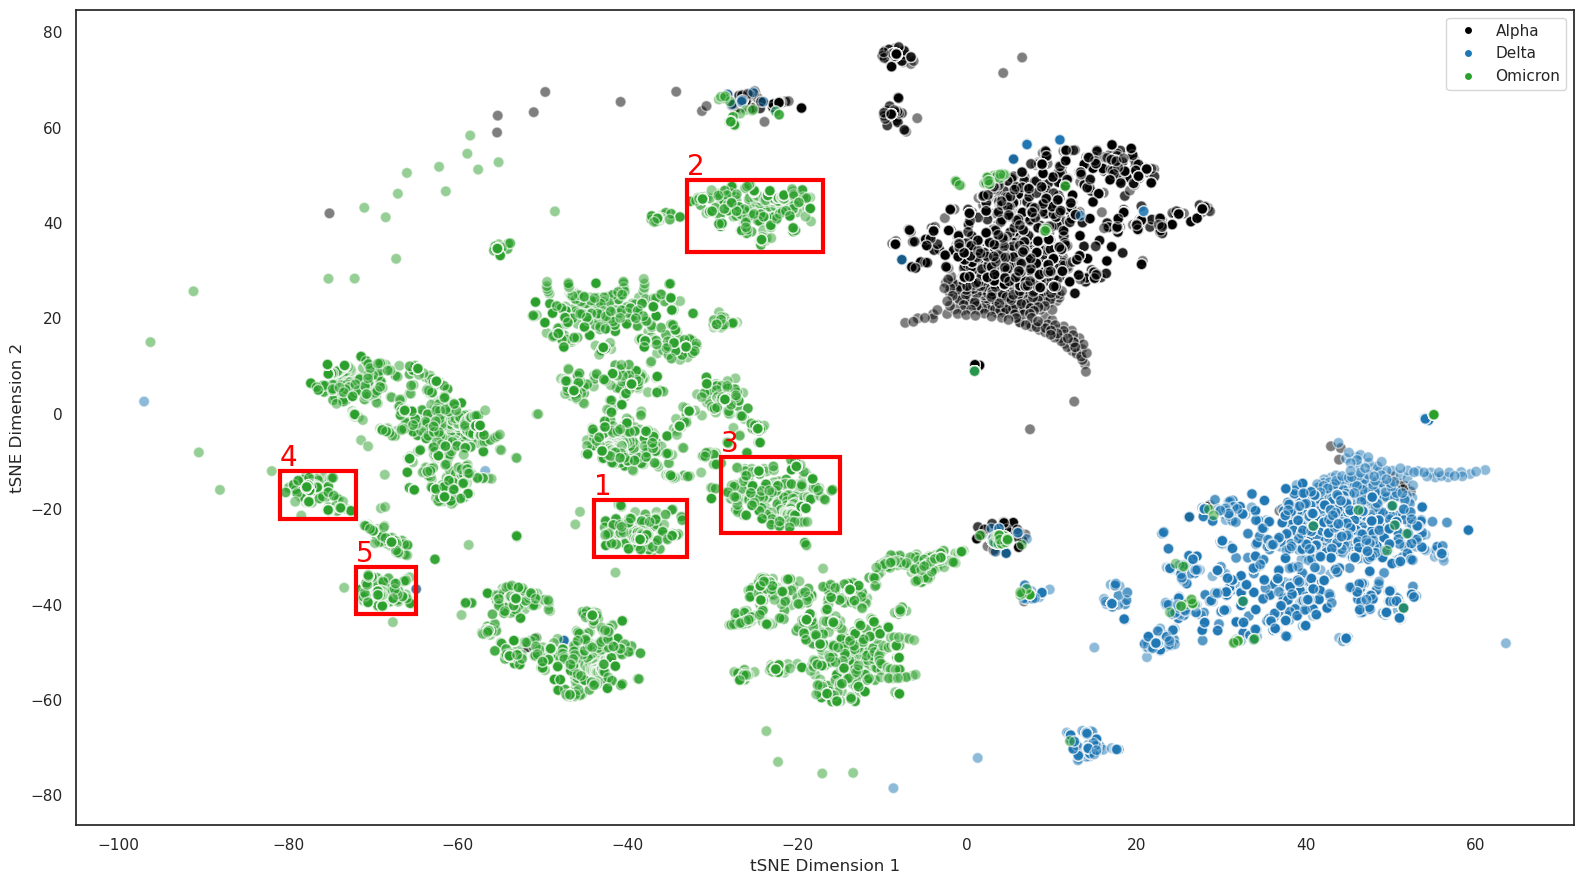

In [48]:
omicron_cluster1 = {'DIM_1_min': -44,
                  'DIM_1_max': -33,
                  'DIM_2_min': -30,
                  'DIM_2_max': -18}

omicron_cluster2 = {'DIM_1_min': -33,
                  'DIM_1_max': -17,
                  'DIM_2_min': 34,
                  'DIM_2_max': 49}

omicron_cluster3 = {'DIM_1_min': -29,
                  'DIM_1_max': -15,
                  'DIM_2_min': -25,
                  'DIM_2_max': -9}

omicron_cluster4 = {'DIM_1_min': -81,
                  'DIM_1_max': -72,
                  'DIM_2_min': -22,
                  'DIM_2_max': -12}

omicron_cluster5 = {'DIM_1_min': -72,
                  'DIM_1_max': -65,
                  'DIM_2_min': -42,
                  'DIM_2_max': -32}

omicron_cluster_ranges = [omicron_cluster1, omicron_cluster2, omicron_cluster3,
                          omicron_cluster4, omicron_cluster5]

plot_from_embedding_multi_variant(tsne_list, 'tSNE', omicron_cluster_ranges)

Omicron Cluster 1:
   Pango lineage  Cluster %   Lineage %
0      BA.2.12*  79.885057   79.428571
1          BA.2   4.741379    1.731375
2       BA.5.2*   2.011494    0.637523
3    Unassigned   1.867816    1.444444
4      BA.2.11*   1.293103  100.000000

Omicron Cluster 2:
   Pango lineage  Cluster %  Lineage %
0       BA.4.6*  16.366158  80.000000
1       BA.5.2*  15.256588  10.018215
2          BF.7  14.771151  81.297710
3      BF.7.14*   5.409154  93.975904
4    Unassigned   4.576976   7.333333



Omicron Cluster 3:
   Pango lineage  Cluster %  Lineage %
0       BQ.1.1*  77.922926  85.214286
1    Unassigned   3.723057   6.333333
2      BQ.1.18*   1.959504  90.909091
3      BQ.1.25*   1.502286  88.461538
4       BA.4.6*   0.783801   4.067797

Omicron Cluster 4:
   Pango lineage  Cluster %   Lineage %
0       CH.1.1*  65.760870   96.800000
1       BR.2.1*   7.427536  100.000000
2    Unassigned   5.615942    3.444444
3          CA.7   2.355072   92.857143
4          BR.2   2.173913  100.000000

Omicron Cluster 5:
   Pango lineage  Cluster %   Lineage %
0       BN.1.3*  31.860037   96.111111
1       BN.1.2*  20.441989   98.230088
2          BN.1   5.709024   96.875000
3       BN.1.1*   5.709024  100.000000
4       BN.1.4*   5.340700   93.548387



<Figure size 1600x900 with 0 Axes>

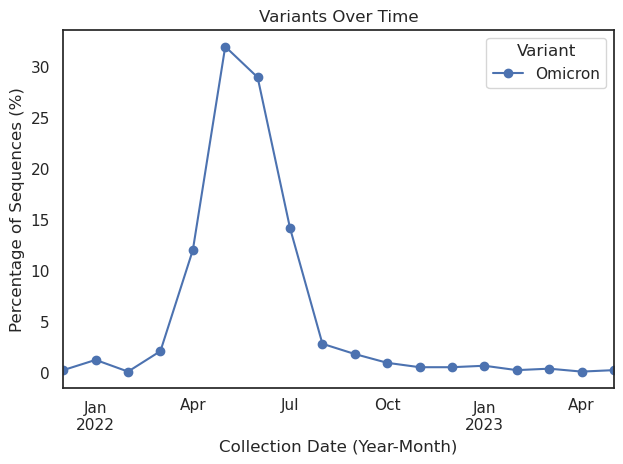

<Figure size 1600x900 with 0 Axes>

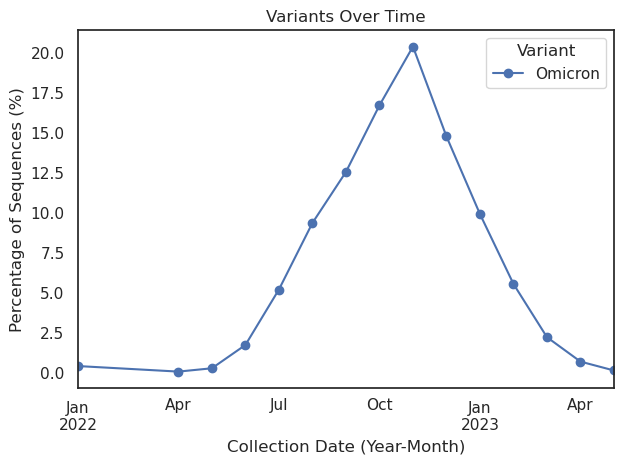

<Figure size 1600x900 with 0 Axes>

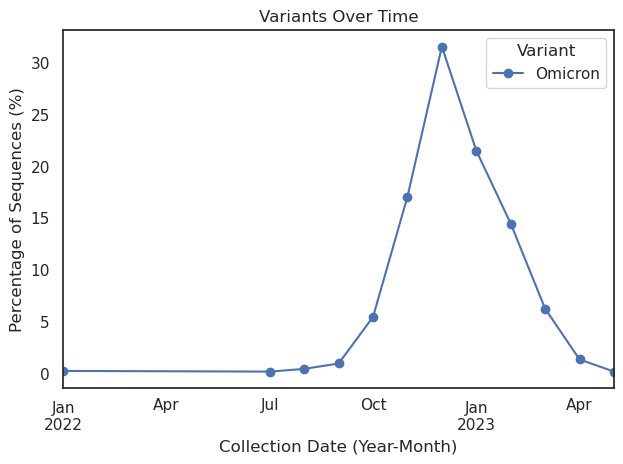

<Figure size 1600x900 with 0 Axes>

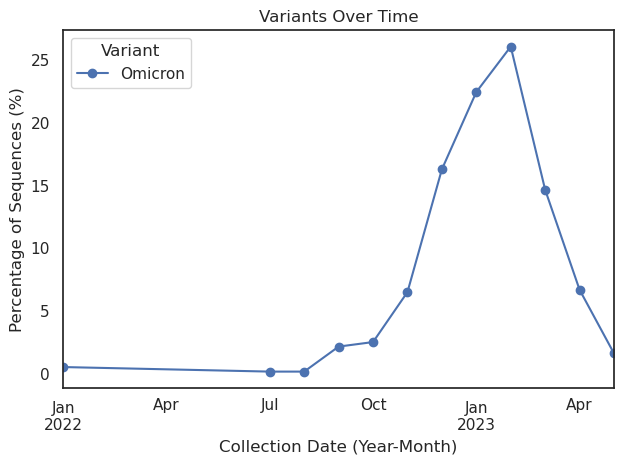

<Figure size 1600x900 with 0 Axes>

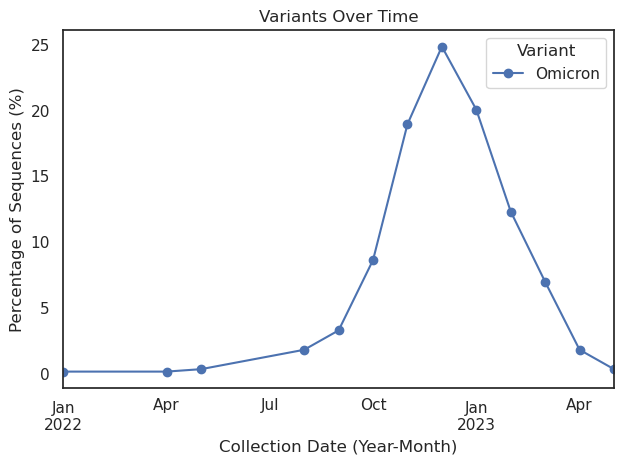

In [49]:
subsampled_df = pd.merge(df, metadata_df, on='seq_id', how='left')

for i in range(len(omicron_cluster_ranges)):
    omicron_cluster = omicron_cluster_ranges[i]
    omicron_majority_cluster_df = df[(df['DIM_1'] >= omicron_cluster['DIM_1_min']) &
                                     (df['DIM_1'] <= omicron_cluster['DIM_1_max']) &
                                     (df['DIM_2'] >= omicron_cluster['DIM_2_min']) &
                                     (df['DIM_2'] <= omicron_cluster['DIM_2_max'])]
    omicron_majority_cluster_df.reset_index(drop=True, inplace=True)

    omicron_cluster_df = pd.merge(omicron_majority_cluster_df, metadata_df, on='seq_id', how='left')
    omicron_lineage_cluster_perc_df = pango_lineage_cluster_lineage_percent_single_variant(omicron_cluster_df, subsampled_df)
    omicron_lineage_cluster_perc_df = omicron_lineage_cluster_perc_df[['Pango lineage', 'Cluster %', 'Lineage %']]
    print(f"Omicron Cluster {i+1}:\n {omicron_lineage_cluster_perc_df.head(5)}\n")

    save_as = os.path.join(old_run_dir, f"data_collected_variant_omicron_cluster{i}.pdf")
    date_collected_vs_variant(save_as, omicron_cluster_df)